In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl

%pylab inline --no-import-all

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


import tensorflow as tf

tf.enable_eager_execution()


Populating the interactive namespace from numpy and matplotlib


In [2]:
from definitions import *

In [3]:
## define your image grid

x = np.arange(128)
xx, yy = np.meshgrid(x,x)

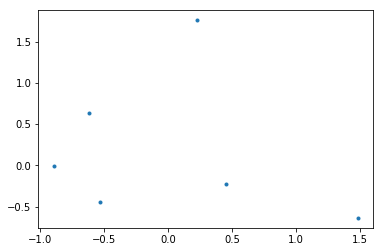

In [4]:
## define your interferometric array

coords = np.random.randn(6,2)
plt.plot(coords[:,0],coords[:,1],'.')
np.savetxt('coords.txt',coords)

In [5]:
from kpi import kpi

In [6]:
op = kpi(file='coords.txt',bsp_mat=None)

File coords.txt isn't a valid Ker-phase data structure
Creating from coordinate file
15 distinct baselines were identified
10 Kernel Phases identified.


In [7]:
bs = kpi(file='coords.txt',bsp_mat='sparse')

File coords.txt isn't a valid Ker-phase data structure
Creating from coordinate file
15 distinct baselines were identified
10 Kernel Phases identified.
Now calculating bispectrum
Calculating bispectrum matrix. Will take a few minutes.
Done 0 of 6 .  10  bispectra found. Time taken: 0.0 sec
Done. Total time taken: 0.0 mins
Found 20 bispectra
Doing sparse svd
Matrix rank: 10
Reduced-rank bispectrum matrix calculated.
Matrix shape (10, 15)
Time taken: 0.0 mins


In [11]:
bs.uv_to_bsp

array([[ 0.28727393,  0.01192423,  0.11633484,  0.10683471, -0.28938862,
        -0.16372633, -0.4594611 , -0.13037376,  0.05835168,  0.3973324 ,
         0.10590025,  0.08390968, -0.31429198, -0.37757036,  0.36449645],
       [-0.16302236, -0.27221972, -0.34352405,  0.07682598, -0.18667339,
         0.10044218, -0.20849709,  0.26604801,  0.41917592,  0.13145713,
         0.2878536 , -0.40765127,  0.39340548, -0.13219515, -0.0441458 ],
       [-0.09899456, -0.15472797,  0.58103769,  0.14407575,  0.13086603,
         0.09807034, -0.21731196, -0.39443825,  0.16347211,  0.0965614 ,
        -0.32587974, -0.37606114,  0.23290961,  0.19652265,  0.04256893],
       [ 0.28626041, -0.0283174 , -0.01067355,  0.18728858, -0.56587303,
        -0.53270223,  0.20879013, -0.24062167, -0.09422706, -0.17784263,
         0.04311728, -0.14551037,  0.20466361,  0.16789616, -0.2072937 ],
       [-0.11688159, -0.34651937,  0.04342724, -0.19960305,  0.05214885,
        -0.45288107, -0.13060988,  0.23835939, 

Text(0, 0.5, '$v$')

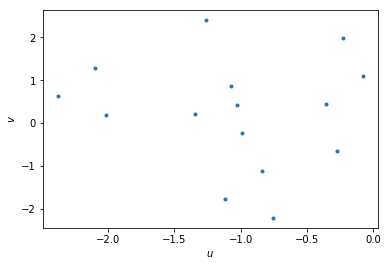

In [13]:
plt.plot(bs.uv[:,0],bs.uv[:,1],'.')
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')

In [14]:
## create p2vm matrix

p2vm_sin = np.zeros((bs.uv.shape[0],xx.ravel().shape[0]))

for j in range(bs.uv.shape[0]):
    p2vm_sin[j,:] = np.ravel(np.sin(xx*bs.uv[j,0]+yy*bs.uv[j,1]))
    
p2vm_cos = np.zeros((bs.uv.shape[0],xx.ravel().shape[0]))

for j in range(bs.uv.shape[0]):
    p2vm_cos[j,:] = np.ravel(np.cos(xx*bs.uv[j,0]+yy*bs.uv[j,1]))

In [15]:
## define gaussian image - from halophot

def gaussian_psf(pixels,xp,yp,width):
    # make rr array
    npix = np.shape(pixels[0])[0]
    xx,yy = np.meshgrid(np.arange(npix)-npix/2.,np.arange(npix)-npix/2.)
    rr2 = (xx-xp)**2 + (yy-yp)**2
    
    return 1./(width*np.sqrt(2.*np.pi))*np.exp(-0.5*(rr2/width**2))

def normalize(vector):
    return (vector-vector.min())/(vector.max()-vector.min())

In [16]:
widths = [5,10,20,20]
xs = [20,-20,-50,90]
ys = [20,60,20,-60]
fs = [5,10,20,30]

In [17]:
image = np.zeros_like(xx)*1.
pixels = np.zeros_like(xx)
for j, w in enumerate(widths):
    image += fs[j]*gaussian_psf(pixels,xs[j]/2.,ys[j]/2.,w/2.)
    
image = normalize(image)
# image /= image.sum()

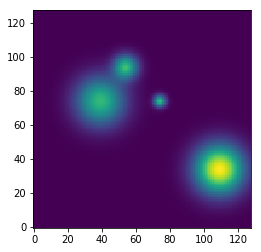

In [18]:
plt.imshow(image)

In [149]:
data_sin = np.dot(p2vm_sin,image.ravel())
data_cos = np.dot(p2vm_cos,image.ravel())
vis2s = np.abs(data_sin**2 + data_cos**2)
closure_phases = np.dot(bs.uv_to_bsp,np.angle(data_cos+1.j*data_sin))
recon = np.zeros_like(image)*1. # placeholder


### Now let's build the forwards model in TensorFlow

In [150]:
# create tensor to hold cosine and sine projection operators
T = tf.float64

# create tensor to hold cosine and sine projection operators
cos_tensor = tf.constant(p2vm_cos.T,dtype=T)
sin_tensor = tf.constant(p2vm_sin.T,dtype=T)
bs_tensor = tf.constant(bs.uv_to_bsp,dtype=T)


# create tensor to hold your data
vis2s_tensor = tf.constant(vis2s,dtype=T)
cp_tensor = tf.constant(closure_phases,dtype=T)
data_tensor = tf.concat([vis2s_tensor,cp_tensor],0)

# create tensor to hold your uncertainties
vis2s_err_tensor = tf.constant(np.ones_like(vis2s)*np.median(vis2s)/5.,dtype=T)
cp_err_tensor = tf.constant(np.ones_like(closure_phases)*np.median(closure_phases)/5.,dtype=T)
error_tensor = tf.concat([vis2s_err_tensor,cp_err_tensor],0)

# create tensor to hold your image model
image_tensor = tf.Variable(normalize(recon[:,:,np.newaxis])+1e-15,dtype=T)



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [156]:
class Data_Generator(object):

    def __init__(self,train_batch_size=1,test_batch_size=1, impix_side = 192, im_size=128):
        self.im_size = im_size
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.impix_side = impix_side

    def gen_source(self):
        Im = np.ones((self.im_size,self.im_size))
        return Im

    def draw_im(self,train_or_test):
        if (train_or_test=="train"):
            np.random.seed(seed=None)
            num_samples = self.train_batch_size
        if (train_or_test=="test"):
            np.random.seed(seed=136)
            num_samples = self.test_batch_size
        
        self.IM_tr = np.zeros((num_samples,self.im_size,self.im_size))
        for i in range(num_samples):
            
            #parameters for im, here it's just an example  
            x = np.random.uniform(low=-1.0, high=1.)
            
            
            if (train_or_test=="train"):
                self.IM_tr[i,:,:] = self.gen_source()

            if (train_or_test=="test"):
                self.IM_ts[i,:,:] = self.gen_source()
 
        return

class Phys_Mod(object):

    def __init__(self, numpix_side = 192):
        self.numpix_side = numpix_side
                
    def physical_model(self, IM):
        
        sin_model = tf.tensordot(IM.ravel(),sin_tensor,axes=1)
        cos_model = tf.tensordot(IM.ravel(),cos_tensor,axes=1)
        vis2s = tf.abs(sin_model**2+cos_model**2)  
        phases = tf.angle(tf.complex(data_cos,data_sin))
        cps = tf.tensordot(bs_tensor,phases,axes=1)
        return tf.concat([vis2s,cps],axis=0)

    def simulate_noisy_image(self, IM, noise_rms=0.1):
        IM = self.physical_model(IM)
        noise = tf.random_normal(tf.shape(IM),mean=0.0,stddev = noise_rms,dtype=T)
        IM = IM + noise
        self.noise_rms = noise_rms
        return IM

    def log_likelihood(Data,Model,noise_rms):
        #logL = 0.5 * tf.reduce_mean(tf.reduce_mean((Data - Model)**2, axis=2 ), axis=1 )
        logL = 0.5 * tf.math.reduce_mean(tf.square(D - M), axis=1 )/ noise_sig**2
        return logL

In [124]:
train_batch_size = 4
num_steps = 10
num_features = 512
state_size = 128
im_size = recon.shape[0]
noise_rms = 0.01


In [125]:
IM_gen = Data_Generator(train_batch_size=train_batch_size,test_batch_size=train_batch_size,im_size=im_size)
Phys_Mod_obj = Phys_Mod()


In [126]:
physical_model = Phys_Mod_obj.physical_model

In [158]:
# test our tensorflow model is giving the same results on the input image
print(physical_model(image))
print(data_tensor)

tf.Tensor(
[ 1.29151050e-07  4.78019813e-08  2.05739088e-01  9.08567742e-02
  4.38569135e-08  6.18352902e-08  5.32808880e-03  3.12533124e-01
  9.11893719e-01  3.29864522e-03  1.19143139e-07  6.06425677e+01
  3.24205873e+01  5.46320436e-06  4.59419266e-01  2.31175179e+00
 -1.23316710e+00  2.18955092e+00  3.47178012e+00  1.44864939e+00
 -1.21568251e+00  1.70724082e-01 -1.24277054e+00  1.78727267e+00
 -2.03262609e-01], shape=(25,), dtype=float64)
tf.Tensor(
[ 1.29151050e-07  4.78019813e-08  2.05739088e-01  9.08567742e-02
  4.38569135e-08  6.18352902e-08  5.32808880e-03  3.12533124e-01
  9.11893719e-01  3.29864522e-03  1.19143139e-07  6.06425677e+01
  3.24205873e+01  5.46320436e-06  4.59419266e-01  2.31175179e+00
 -1.23316710e+00  2.18955092e+00  3.47178012e+00  1.44864939e+00
 -1.21568251e+00  1.70724082e-01 -1.24277054e+00  1.78727267e+00
 -2.03262609e-01], shape=(25,), dtype=float64)


### It gives the same results! Hurrah!

In [159]:
IM_gen.draw_im("train")


In [135]:
noisy_data = Phys_Mod_obj.simulate_noisy_image(IM_gen.IM_tr[0,:,:],noise_rms)
